# Análisis Resultados de aprendizaje y Perfiles de egreso (ETD)
D. Sierra-Porta

## Objetivo y Motivación del Análisis

Este cuaderno tiene como propósito analizar cuantitativamente la alineación semántica entre los **Resultados de Aprendizaje (RAs)** y los **Perfiles de Egreso** de los programas académicos pertenecientes a la **Escuela de Transformación Digital** de la UTB. El análisis busca evaluar el grado de coherencia interna y consistencia formativa mediante técnicas avanzadas de ciencia de datos, incluyendo modelos de lenguaje, métricas de similitud y modelado temático.

La motivación principal surge del proceso de rediseño curricular emprendido por la universidad a partir de enero de 2025, con el fin de asegurar que las competencias declaradas por los programas estén en sintonía con los propósitos formativos institucionales y los desafíos sociales, tecnológicos y profesionales del Caribe colombiano y del contexto global.

Este cuaderno constituye una herramienta analítica que puede ser replicada, extendida y adaptada por otros programas o escuelas interesadas en implementar procesos automatizados de evaluación y reflexión curricular basados en análisis semántico computacional.

## Carga de datos, preparación inicial y embeddings

En esta sección se realiza la carga de los archivos Excel que contienen los Resultados de Aprendizaje (RAs) y los Perfiles de Egreso por programa. Luego, se inicializa el modelo preentrenado **Sentence-BERT (SBERT)** utilizando la variante `"all-MiniLM-L6-v2"` para transformar tanto los RAs como los perfiles en vectores numéricos (embeddings).

Este proceso permite comparar computacionalmente los textos mediante el cálculo de similitud semántica, particularmente utilizando la métrica de **similitud del coseno**, la cual mide cuán alineados están los vectores correspondientes a un RA y su perfil de egreso.

Los resultados se almacenan en un `DataFrame` y se imprimen los cinco RAs con mayor similitud con su respectivo perfil para cada programa.

In [1]:
# Instalar dependencias si es necesario
# !pip install sentence-transformers pandas openpyxl

import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 2.0
# Cargar el archivo Excel
file_path = "Book1.xlsx"
ra_df = pd.read_excel(file_path, sheet_name="RA")
perfil_df = pd.read_excel(file_path, sheet_name="Perfil")

# Inicializar modelo SBERT
model = SentenceTransformer("all-MiniLM-L6-v2")

# Programas disponibles
programas = ["CDAT","ISCO","CSOC","MKTD"]

# Extraer RAs y perfiles
ra_por_programa = {
    programa: ra_df[programa].dropna().tolist()
    for programa in programas
}
perfil_por_programa = {
    programa: perfil_df[programa].dropna().values[0]
    for programa in programas
}

# Embeddings de perfiles
perfil_embeddings = {
    programa: model.encode(perfil, convert_to_tensor=True)
    for programa, perfil in perfil_por_programa.items()
}

# Comparar cada RA con su perfil correspondiente
results = []
for programa in programas:
    ra_textos = ra_por_programa[programa]
    ra_embeddings = model.encode(ra_textos, convert_to_tensor=True)
    perfil_embedding = perfil_embeddings[programa]

    # Similaridad coseno
    similitudes = util.cos_sim(ra_embeddings, perfil_embedding).squeeze().tolist()

    for ra, score in zip(ra_textos, similitudes):
        results.append({
            "Programa": programa,
            "RA": ra.strip(),
            "Similitud_con_Perfil": float(score)
        })

# Crear DataFrame final
df_resultados = pd.DataFrame(results)

# Mostrar top resultados por programa
for programa in programas:
    top = df_resultados[df_resultados["Programa"] == programa].sort_values("Similitud_con_Perfil", ascending=False).head(5)
    print(f"\n📘 Top 5 coincidencias para {programa}:\n", top[["RA", "Similitud_con_Perfil"]])



📘 Top 5 coincidencias para CDAT:
                                                   RA  Similitud_con_Perfil
5  CDAT6: Trabajo de manera efectiva como miembro...              0.525297
1  CDAT2: Diseño soluciones basadas en datos para...              0.524608
6  CDAT7: Comprendo y me adapto a entornos tecnol...              0.466518
4  CDAT5: Comprendo y aplico principios éticos y ...              0.460957
3  CDAT4: Comunico efectivamente con un rango amp...              0.423745

📘 Top 5 coincidencias para ISCO:
                                                    RA  Similitud_con_Perfil
13  ISCO7: Comprendo y me adapto a entornos tecnol...              0.695143
7   ISCO1: Identifico, formulo y resuelvo problema...              0.576851
8   ISCO2: Aplico el diseño de ingeniería en la ge...              0.508369
9   ISCO3: Desarrollo y llevo a cabo experimentaci...              0.506426
10  ISCO4: Me comunico eficazmente con diversos pú...              0.504723

📘 Top 5 coincidencias p

## Cálculo detallado de métricas semánticas entre RAs y perfiles de egreso

En este bloque se amplía el análisis de alineación semántica entre los Resultados de Aprendizaje (RAs) y los perfiles de egreso, aplicando múltiples métricas estadísticas y geométricas sobre los vectores generados por el modelo SBERT (`"all-MiniLM-L6-v2"`).

Para cada par (RA, perfil) se calcularon las siguientes métricas:

- **Similitud del coseno inversa** (`scipy.spatial.distance.cosine`), que mide la disimilitud angular entre los vectores.
- **Correlación de Pearson**, que evalúa la dependencia lineal entre las dimensiones vectoriales.
- **Correlación de Kendall** y **Spearman**, que miden concordancia ordinal y no lineal respectivamente.

Para facilitar la interpretación, las correlaciones fueron transformadas como \( 1 - |\text{correlación}| \), de modo que valores más cercanos a cero indican mayor alineación semántica. El resultado se almacena en un `DataFrame` y se guarda en un archivo Excel para facilitar su análisis posterior.

In [2]:
# !pip install sentence-transformers pandas scipy openpyxl
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine, euclidean, cityblock, jaccard, hamming
from scipy.stats import pearsonr, kendalltau, spearmanr

# Convertir todos los textos a embeddings
results2 = []
for programa in programas:
    perfil_embedding = model.encode(perfil_por_programa[programa], convert_to_numpy=True)
    ra_textos = ra_por_programa[programa]

    for ra in ra_textos:
        ra_embedding = model.encode(ra, convert_to_numpy=True)

        # Métricas
        cosine_sim = cosine(ra_embedding, perfil_embedding)
        pear_corr, _ = pearsonr(ra_embedding, perfil_embedding)
        kend_corr, _ = kendalltau(ra_embedding, perfil_embedding)
        spea_corr, _ = spearmanr(ra_embedding, perfil_embedding)
        eucl_dist = euclidean(ra_embedding, perfil_embedding)
        manh_dist = cityblock(ra_embedding, perfil_embedding)

        # Normalizaciones en [0,1]
        sim_euclid = 1 / (1 + eucl_dist)
        sim_manhattan = 1 / (1 + manh_dist)*10
        
        results2.append({
            "Programa": programa,
            "RA": ra.strip(),
            "Cosine_Similarity": cosine_sim,
            #"Pearson_Correlation": 1-abs(pear_corr),
            #"Kendall_Correlation": 1-abs(kend_corr),
            #"Spearman_Correlation": 1-abs(spea_corr),
            "Pearson_Correlation": 1 - abs(pear_corr),
            "Kendall_Correlation": 1 - abs(kend_corr),
            "Spearman_Correlation": 1 - abs(spea_corr),
            "Euclidean_Similarity": sim_euclid,
            "Manhattan_Similarity": sim_manhattan
        })

df_resultados2 = pd.DataFrame(results2)

# Guardar resultados
df_resultados2.to_excel("RA_vs_Perfil_Metricas2.xlsx", index=False)

# Ver ejemplo
df_resultados2


,Programa,RA,Cosine_Similarity,Pearson_Correlation,Kendall_Correlation,Spearman_Correlation,Euclidean_Similarity,Manhattan_Similarity
0,CDAT,CDAT1: Resuelvo problemas complejos en cienci...,0.621561,0.622834,0.761532,0.648665,0.472823,0.536564
1,CDAT,CDAT2: Diseño soluciones basadas en datos para...,0.475392,0.475836,0.661091,0.512126,0.506308,0.611298
2,CDAT,CDAT3: Construyo soluciones computacionales ro...,0.684560,0.686442,0.786200,0.689933,0.460810,0.520657
3,CDAT,CDAT4: Comunico efectivamente con un rango amp...,0.576255,0.577445,0.720599,0.600421,0.482265,0.569637
4,CDAT,CDAT5: Comprendo y aplico principios éticos y ...,0.539044,0.539849,0.705804,0.573948,0.490603,0.581141
5,CDAT,CDAT6: Trabajo de manera efectiva como miembro...,0.474703,0.476273,0.658290,0.511286,0.506490,0.617755
6,CDAT,CDAT7: Comprendo y me adapto a entornos tecnol...,0.533482,0.534890,0.700936,0.563897,0.491899,0.579678
7,ISCO,"ISCO1: Identifico, formulo y resuelvo problema...",0.423149,0.424343,0.608491,0.442421,0.520848,0.656703
8,ISCO,ISCO2: Aplico el diseño de ingeniería en la ge...,0.491631,0.493840,0.654890,0.502864,0.502110,0.610168
9,ISCO,ISCO3: Desarrollo y llevo a cabo experimentaci...,0.493574,0.495472,0.670746,0.527995,0.501617,0.610351


In [3]:
from sklearn.preprocessing import MinMaxScaler

metricas = ["Cosine_Similarity", "Pearson_Correlation", "Kendall_Correlation", "Spearman_Correlation",
           "Euclidean_Similarity", "Manhattan_Similarity"]
df_normalizado = df_resultados2.copy()

In [4]:
#df_normalizado=df_normalizado[["Programa","RA","Cosine_Similarity","Pearson_Correlation","Kendall_Correlation","Spearman_Correlation"]]

## Visualización de métricas semánticas mediante mapas de calor compactos

Este bloque de código genera mapas de calor (heatmaps) para visualizar las métricas de similitud semántica entre cada Resultado de Aprendizaje (RA) y el perfil de egreso correspondiente, desagregados por programa académico. 

Dado que los RAs pueden contener textos extensos, se aplica una función personalizada para dividirlos en múltiples líneas, manteniendo etiquetas legibles y compactas. Esto mejora la presentación visual en los ejes del gráfico sin perder la claridad del contenido.

Cada gráfico muestra los valores individuales para las métricas consideradas, incluyendo similitud del coseno y correlaciones estadísticas, destacando aquellos RAs con mayor (o menor) alineación con el perfil. Este tipo de visualización facilita la detección de patrones temáticos, coherencias internas y posibles redundancias, y constituye una herramienta efectiva para retroalimentación curricular basada en datos.

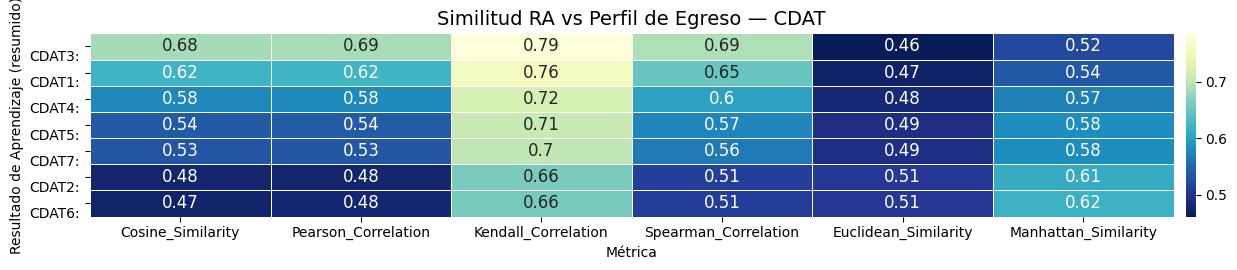

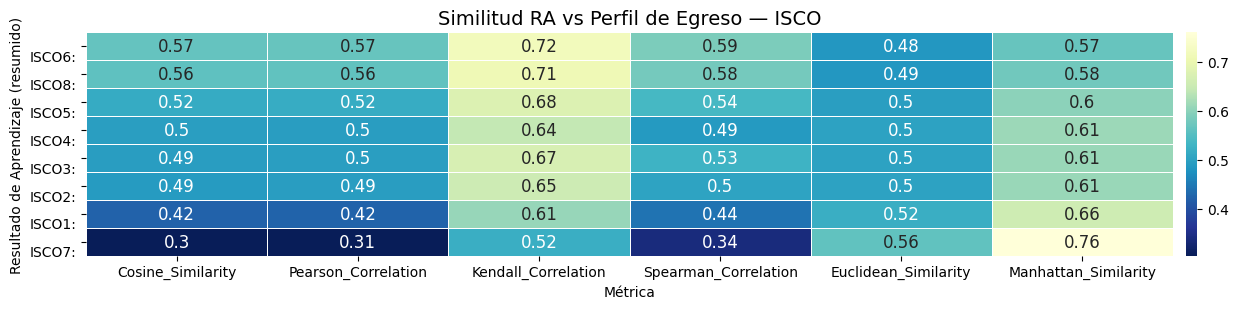

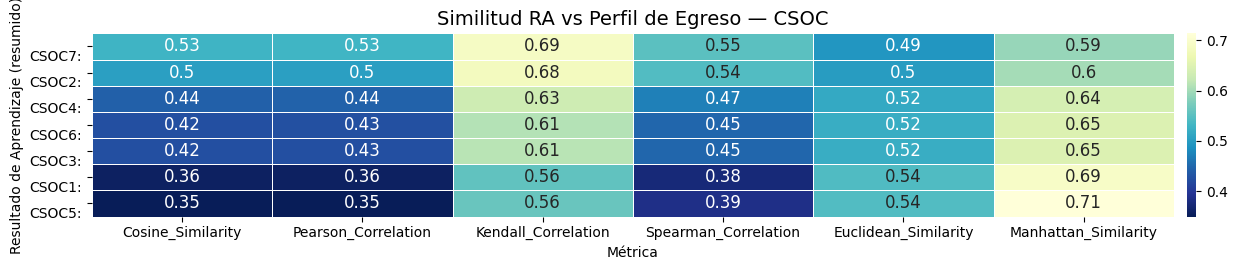

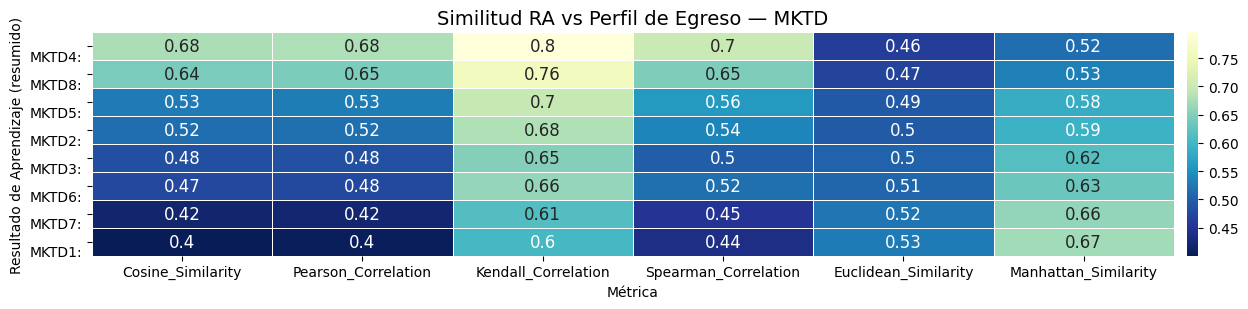

In [5]:
# Función para dividir texto largo en varias líneas
def split_text(text, width=2, max_lines=3):
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) <= width:
            current_line += " " + word if current_line else word
        else:
            lines.append(current_line)
            current_line = word
            if len(lines) == max_lines - 1:
                break
    if current_line:
        lines.append(current_line)
    return "\n".join(lines)

# Aplicar la función para generar etiquetas legibles
df_normalizado["RA_wrapped"] = df_normalizado["RA"].apply(lambda x: split_text(x, width=2, max_lines=2))

# Redibujar heatmaps por programa con etiquetas más compactas
for programa in programas:
    subset = df_normalizado[df_normalizado["Programa"] == programa].copy()
    subset = subset.sort_values("Cosine_Similarity", ascending=False)

    plt.figure(figsize=(14, 0.4 * len(subset)))
    sns.heatmap(
        subset[metricas],
        annot=True,
        cmap="YlGnBu_r",
        yticklabels=subset["RA_wrapped"],
        cbar=True,
        linewidths=0.5,
        annot_kws={"fontsize":12},
        cbar_kws={"pad":0.01}
    )

    plt.title(f"Similitud RA vs Perfil de Egreso — {programa}", fontsize=14)
    plt.xlabel("Métrica")
    plt.xticks(rotation=0,ha="center")
    plt.yticks(rotation=0,ha="right",va="center_baseline")
    plt.ylabel("Resultado de Aprendizaje (resumido)")
    plt.savefig("fig1_{}.png".format(programa),dpi=300,bbox_inches='tight')
    plt.tight_layout()
    plt.show()


## Comparación global de métricas promedio mediante Radar Plot

Este bloque de código construye una visualización tipo radar (*Radar Plot*) que resume el comportamiento promedio de las métricas semánticas calculadas para cada programa académico. Para ello, se computa el valor medio de cada métrica (coseno, Pearson, Spearman, Kendall) sobre todos los Resultados de Aprendizaje de cada programa, y se proyectan en un plano polar para facilitar la comparación visual.

Esta visualización permite identificar de manera intuitiva las fortalezas relativas de cada programa en términos de coherencia semántica interna, así como detectar posibles áreas de oportunidad para fortalecer la alineación entre competencias y perfiles de egreso. Su interpretación conjunta con los mapas de calor anteriores brinda una perspectiva tanto local como global del comportamiento semántico de los planes académicos evaluados.

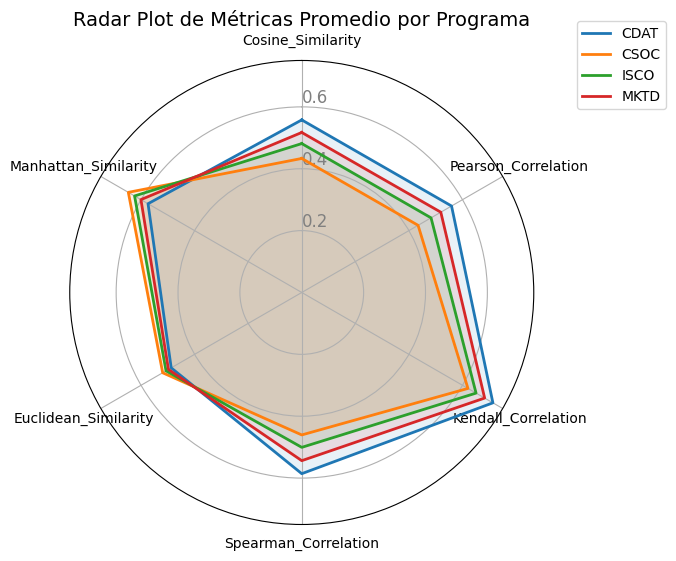

In [6]:
from math import pi

# Calcular promedios por programa
mean_metrics = df_normalizado.groupby("Programa")[metricas].mean().reset_index()

# Preparar datos para radar plot
categories = metricas
N = len(categories)

# Angulos para cada eje
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # cerrar el gráfico

# Crear gráfico
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

for i, row in mean_metrics.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row["Programa"])
    ax.fill(angles, values, alpha=0.1)

# Ajustes estéticos
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories, fontsize=10)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.9], ["0.2", "0.4", "0.6", "0.9"], color="gray", size=12)
plt.ylim(0, 0.75)
plt.title("Radar Plot de Métricas Promedio por Programa", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("RadarPlot.png".format(programa),dpi=300,bbox_inches='tight')
plt.show()

## Agrupamiento jerárquico de Resultados de Aprendizaje

Este bloque de código implementa un análisis de *clustering jerárquico* sobre los Resultados de Aprendizaje (RAs), utilizando como base las métricas semánticas previamente calculadas entre cada RA y el perfil de egreso correspondiente. El objetivo de esta visualización es identificar grupos naturales de RAs que exhiben comportamientos similares en términos de alineación semántica.

Para ello, se estandarizan las métricas mediante \texttt{StandardScaler} y se aplica el método de enlace de Ward, que minimiza la varianza dentro de los clústeres. El dendrograma resultante muestra la estructura jerárquica de agrupamiento, permitiendo observar afinidades entre RAs, redundancias temáticas o posibles núcleos conceptuales en el diseño curricular. Esta herramienta puede servir como guía exploratoria para reorganizar, consolidar o diversificar componentes formativos dentro de los programas.

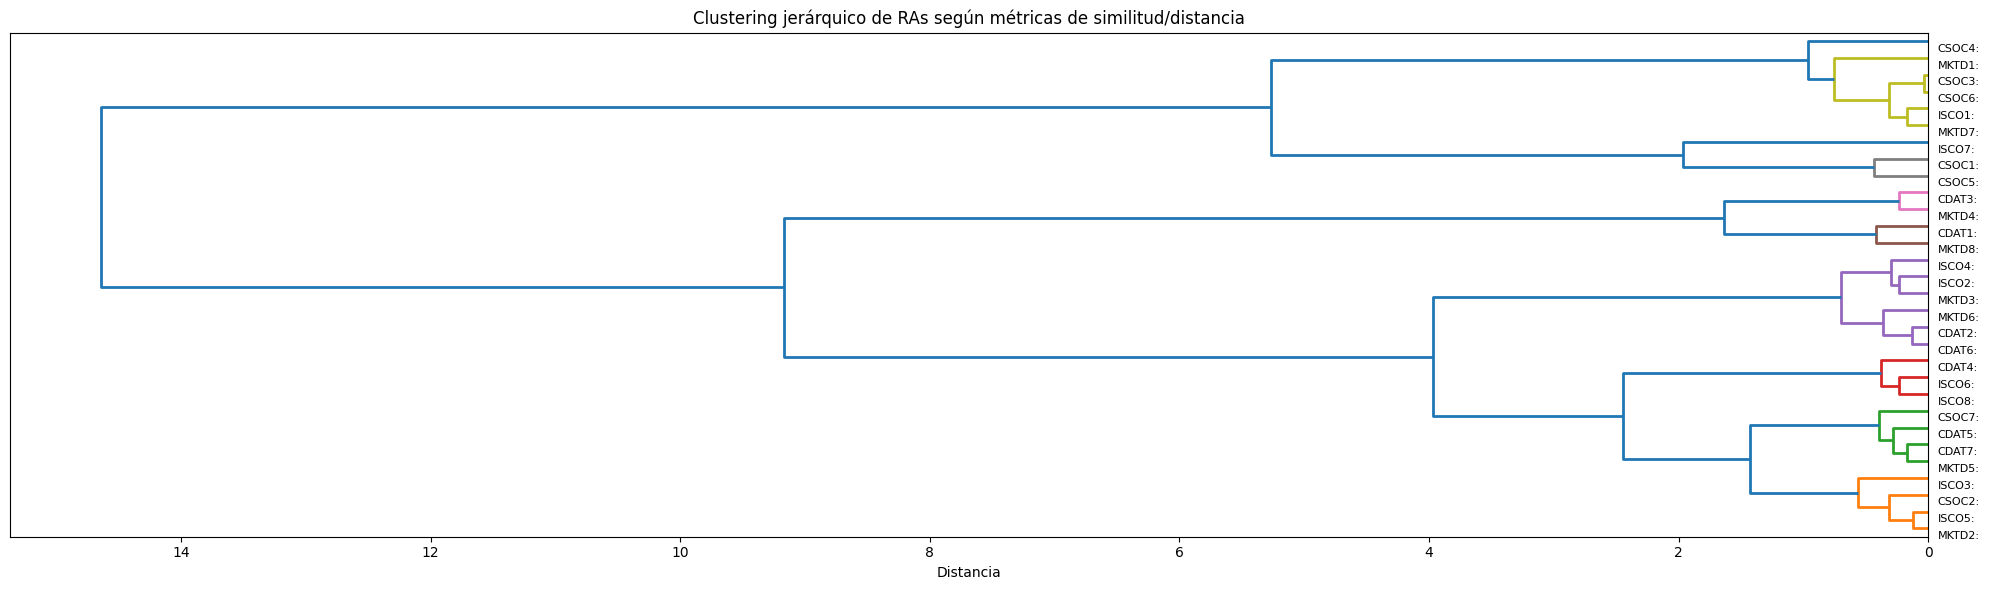

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy


# Subconjunto completo o por programa
subset_clustering = df_normalizado.copy()

# RA + métricas
X = subset_clustering[metricas].values
labels = subset_clustering["RA_wrapped"].values

# Estandarizar
X_scaled = StandardScaler().fit_transform(X)

# Clustering jerárquico
linked = linkage(X_scaled, method="ward")

# Dendrograma con ajuste de texto
plt.figure(figsize=(20, 0.2 * len(labels)))
dendrogram(
    linked,
    orientation="left",
    labels=labels,
    leaf_font_size=8,
    distance_sort='descending',
    show_leaf_counts=True,
    color_threshold=0.9,
    show_contracted=True
)

plt.title("Clustering jerárquico de RAs según métricas de similitud/distancia")
plt.xlabel("Distancia")

# ⬅️ Esto da más espacio a las etiquetas
plt.subplots_adjust(left=0.7)
plt.savefig("Dendo.png",dpi=300,bbox_inches='tight')
plt.tight_layout()
plt.show()


## Modelado de Temas con LDA

Este bloque de código aplica el algoritmo de *Latent Dirichlet Allocation* (LDA) para descubrir temas latentes en los Resultados de Aprendizaje (RAs) de todos los programas. El objetivo es identificar agrupamientos semánticos que puedan revelar ejes temáticos transversales o diferenciadores entre los programas.

El procedimiento inicia con el preprocesamiento textual: se convierte a minúsculas, se eliminan palabras vacías (stopwords) en español, se filtran tokens alfabéticos y se aplica lematización. Posteriormente, se vectoriza el corpus utilizando \texttt{CountVectorizer}, considerando una frecuencia mínima de aparición por palabra para mantener solo términos relevantes.

Luego se entrena un modelo LDA con \texttt{n\_components=4} para extraer cuatro tópicos principales, cuyas palabras clave representativas se imprimen en pantalla. Finalmente, se asigna el tópico dominante a cada RA y se visualiza la distribución de temas por programa académico mediante un gráfico de barras apiladas.

Este tipo de análisis permite detectar focos comunes de formación (por ejemplo, ética profesional, transformación digital, trabajo en equipo, etc.), y brinda evidencia empírica para diseñar rutas curriculares transversales, integrar contenidos o diversificar enfoques temáticos en función del perfil del programa.

[nltk_data] Downloading package stopwords to /Users/neno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/neno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



🔹 Tema #1:
datos | toma | decisiones | principios | transformación

🔹 Tema #2:
aplico | utilizando | estrategias | conocimientos | según

🔹 Tema #3:
soluciones | ingeniería | considerando | comunicación | impacto

🔹 Tema #4:
trabajo | manera | efectiva | soluciones | ciencia


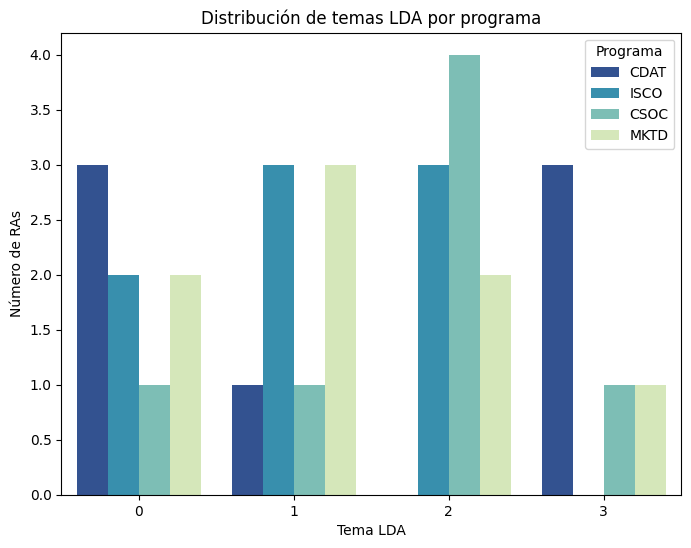

In [8]:
# !pip install pandas sklearn nltk matplotlib seaborn

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

# Preprocesamiento
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))

def preprocess(text):
    tokens = text.lower().split()
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Corpus completo (solo RAs por ahora)
df_ra = df_resultados.copy()
df_ra["RA_clean"] = df_ra["RA"].apply(preprocess)

# Vectorización
vectorizer = CountVectorizer(max_df=0.9, min_df=1)
X = vectorizer.fit_transform(df_ra["RA_clean"])

# Aplicar LDA
lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
lda_model.fit(X)

# Mostrar palabras por tema
def mostrar_top_palabras_por_tema(model, feature_names, n_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n🔹 Tema #{topic_idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

mostrar_top_palabras_por_tema(lda_model, vectorizer.get_feature_names_out())

# Distribución de temas por RA
topic_dist = lda_model.transform(X)
df_ra["Tema_LDA"] = topic_dist.argmax(axis=1)

# Visualización por programa
plt.figure(figsize=(8,6))
sns.countplot(data=df_ra, x="Tema_LDA", hue="Programa", palette="YlGnBu_r")
plt.title("Distribución de temas LDA por programa")
plt.xlabel("Tema LDA")
plt.ylabel("Número de RAs")
plt.show()


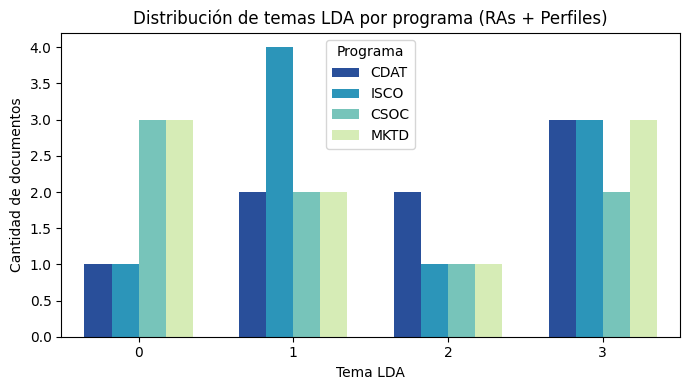

,0,1,2,3,4,5,6
Tema 1,comunicación,profesional,ético,valor,equipos,procesos,universidad
Tema 2,toma,principios,transformación,decisiones,digital,estratégico,uso
Tema 3,trabajo,equipo,ciencia,liderazgo,efectiva,manera,problemas
Tema 4,datos,soluciones,proyectos,estrategias,artificial,inteligencia,diversos


In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import re

# -----------------------------
# 1. Construir df_corpus
# -----------------------------
df_corpus = []

for programa in programas:
    for ra in ra_por_programa[programa]:
        df_corpus.append({
            "Programa": programa,
            "Tipo": "RA",
            "Texto": ra
        })
    perfil = perfil_por_programa[programa]
    df_corpus.append({
        "Programa": programa,
        "Tipo": "Perfil",
        "Texto": perfil
    })

df_corpus = pd.DataFrame(df_corpus)

# -----------------------------
# 2. Limpieza básica sin NLTK
# -----------------------------
stopwords_es = set("""
de la que el en y a los del se las por un para con no una su al lo como más pero sus le ya o este sí porque esta entre
cuando muy sin sobre también me hasta hay donde quien desde todo nos durante todos uno les ni contra otros ese eso ante
ellos e esto mí antes algunos qué unos yo otro otras otra él tanto esa estos mucho quienes nada muchos cual poco ella
estar estas algunas algo nosotros mi mis tú te ti tu tus ellas nosotras vosotras vosotras os mío mía míos mías tuyo tuya
tuyos tuyas suyo suya suyos suyas nuestro nuestra nuestros nuestras vuestro vuestra vuestros vuestras esos esas estoy
estás está estamos estáis están esté estés estemos estéis estén estaré estarás estará estaremos estaréis estarán
estaría estarías estaríamos estaríais estarían estaba estabas estábamos estabais estaban estuve estuviste estuvo
estuvimos estuvisteis estuvieron estuviera estuvieras estuviéramos hubierais estuvieran estuviese estuvieses
estuviésemos estuvieseis estuviesen estando estado estada estados estadas estad he has ha hemos habéis han haya hayas
hayamos hayáis hayan habré habrás habrá habremos habréis habrán habría habrías habríamos habríais habrían había
habías habíamos habíais habían hube hubiste hubo hubimos hubisteis hubieron hubiera hubieras hubiéramos hubierais
hubieran hubiese hubieses hubiésemos hubieseis hubiesen habiendo habido habida habidos habidas soy eres es somos sois
son sea seas seamos seáis sean seré serás será seremos seréis serán sería serías seríamos seríais serían era eras
éramos erais eran fui fuiste fue fuimos fuisteis fueron fuera fueras fuéramos fuerais fueran fuese fueses fuésemos
fueseis fuesen siendo sido cdat isco csoc mktd según considerando utilizando aplico""".split())

def limpiar(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    tokens = texto.split()
    tokens = [t for t in tokens if t not in stopwords_es and len(t) > 2]
    return " ".join(tokens)

df_corpus["Texto_clean"] = df_corpus["Texto"].apply(limpiar)

# -----------------------------
# 3. Vectorización
# -----------------------------
#vectorizer = CountVectorizer(max_df=0.9, min_df=1)
vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=1000)
X = vectorizer.fit_transform(df_corpus["Texto_clean"])

# -----------------------------
# 4. LDA
# -----------------------------
lda = LatentDirichletAllocation(
    n_components=4,
    random_state=55,
    max_iter=50,
    learning_method="batch",        # más estable que 'online'
    learning_decay=0.7,             # más conservador
    doc_topic_prior=0.9,            # α
    topic_word_prior=0.01           # β
)
lda.fit(X)

# -----------------------------
# 5. Tema dominante
# -----------------------------
topic_dist = lda.transform(X)
df_corpus["Tema_LDA"] = topic_dist.argmax(axis=1)

# -----------------------------
# 6. Visualización
# -----------------------------
plt.figure(figsize=(7, 4))
sns.countplot(data=df_corpus, x="Tema_LDA", hue="Programa", palette="YlGnBu_r", width=0.7, saturation=0.9)
plt.title("Distribución de temas LDA por programa (RAs + Perfiles)")
plt.xlabel("Tema LDA")
plt.ylabel("Cantidad de documentos")
plt.tight_layout()
plt.savefig("LDA.png",dpi=300,bbox_inches='tight')
plt.show()

# -----------------------------
# 7. Palabras clave por tema
# -----------------------------
def top_words(model, feature_names, n=7):
    temas = {}
    for idx, topic in enumerate(model.components_):
        temas[f"Tema {idx+1}"] = [feature_names[i] for i in topic.argsort()[:-n-1:-1]]
    return pd.DataFrame.from_dict(temas, orient='index')

df_topicos = top_words(lda, vectorizer.get_feature_names_out(), n=7)
df_topicos

In [10]:
# -----------------------------
# 8. Ver temas asignados a perfiles
# -----------------------------
df_corpus[df_corpus["Tipo"] == "Perfil"][["Programa", "Tema_LDA", "Texto_clean"]]


,Programa,Tema_LDA,Texto_clean
7,CDAT,3,pcadt científicoa datos utb profesional ético ...
16,ISCO,1,pisco egresado programa ingeniería sistemas co...
24,CSOC,0,pcsoc egresado comunicación social universidad...
33,MKTD,0,pmktd egresado marketing transformación digita...


## Salvando archivos de resultados...

In [11]:
df_corpus.to_excel("RA_vs_Perfil_Metricas3_corpus_Temas.xlsx", index=True)

In [12]:
df_topicos.to_excel("RA_vs_Perfil_Metricas4_topicos.xlsx", index=True)